In [647]:
import numpy
numpy.seterr(divide='warn')
import pandas
from tkinter import Tk
from tkinter.filedialog import askdirectory
import seaborn
import matplotlib.pyplot as plt

In [648]:
# Get directories for IMU data
forearmPath = "/Users/alex/Library/Mobile Documents/com~apple~CloudDocs/School/Masters/BME_207/Term Project/IMU Analysis/ForeArmReal20221111"#askdirectory(title='Select Folder Containing Forearm Data') # shows dialog box and return the path
print(forearmPath)
armPath = "/Users/alex/Library/Mobile Documents/com~apple~CloudDocs/School/Masters/BME_207/Term Project/IMU Analysis/ArmReal20221111"#askdirectory(title='Select Folder Containing Arm Data') # shows dialog box and return the path
print(armPath)
foreArmGData = pandas.read_csv("{}/Gyroscope.csv".format(forearmPath))
armGData = pandas.read_csv("{}/Gyroscope.csv".format(armPath))
# Truncate data to have same number of samples (temporary with contrived data)
minDataLength = min(len(armGData), len(foreArmGData))
foreArmGData = foreArmGData[:minDataLength]
armGData = armGData[:minDataLength]
# Initialize gyroscope data array(g1, g2) (2 arrays with # rows equal to # sample and each row [x, y, z])
gDataRaw = numpy.array([numpy.stack([foreArmGData['X (rad/s)'].values, foreArmGData['Y (rad/s)'].values, foreArmGData['Z (rad/s)'].values], 1),\
                    numpy.stack([armGData['X (rad/s)'].values, armGData['Y (rad/s)'].values, armGData['Z (rad/s)'].values], 1)])
# Number of samples a second to resample data at and valiue in Hz
reSamples = 15.0
reSampleRate = 1.0/reSamples
# Calculate new time vectors with sample grouping between samples in seconds
timeVFore = numpy.floor((foreArmGData['Time (s)'].values/reSampleRate))
timeVArm = numpy.floor((armGData['Time (s)'].values/reSampleRate))
#create new data arrays with same timebase
gFore = []
for i in range(numpy.int(numpy.max(timeVFore))):
    newRow1 = numpy.mean(gDataRaw[0][numpy.where(timeVFore == i)], axis=0)
    gFore.append(list(newRow1))
gFore = numpy.array(gFore)
gArm = []
for i in range(numpy.int(numpy.max(timeVArm))):
    newRow2 = numpy.mean(gDataRaw[1][numpy.where(timeVFore == i)], axis=0)
    gArm.append(numpy.array(newRow2))
gArm = numpy.array(gArm)
minLen = min([len(gArm), len(gFore)])
gFore = gFore[:minLen]
gArm = gArm[:minLen]
gData = numpy.array([numpy.array(gFore), numpy.array(gArm)])

/Users/alex/Library/Mobile Documents/com~apple~CloudDocs/School/Masters/BME_207/Term Project/IMU Analysis/ForeArmReal20221111
/Users/alex/Library/Mobile Documents/com~apple~CloudDocs/School/Masters/BME_207/Term Project/IMU Analysis/ArmReal20221111


/var/folders/6b/1zwtp83s1b93_8j_qjyxh2b00000gn/T/ipykernel_60310/3764302723.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  for i in range(numpy.int(numpy.max(timeVFore))):
/var/folders/6b/1zwtp83s1b93_8j_qjyxh2b00000gn/T/ipykernel_60310/3764302723.py:28: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to re

46


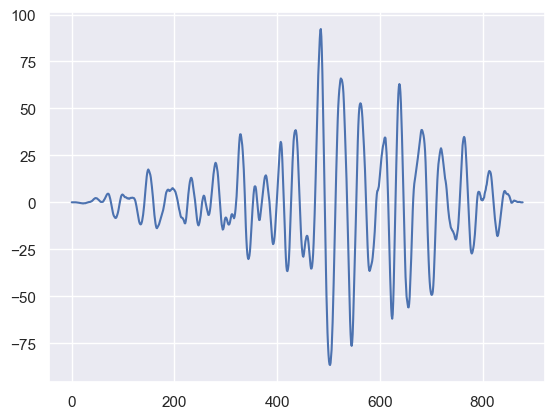

46


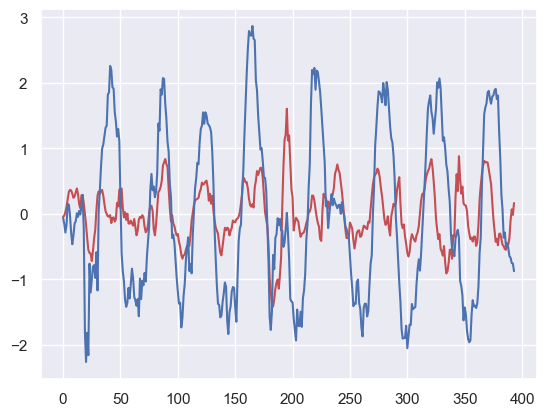

In [649]:
corr = numpy.correlate(gArm[:,0] - numpy.mean(gArm[:,0]), gFore[:,0] - numpy.mean(gFore[:,0]), mode='full')
lag = corr.argmax() - (len(gArm[:,0]) - 1)
print(lag)
plt.plot(corr)
plt.show()
print(lag)
plt.plot(gArm[lag:,0] - numpy.mean(gArm[:,0]), 'r-')
plt.plot(gFore[:-lag,0] - numpy.mean(gFore[:,0]), 'b-')
plt.show()
gArm = gArm[lag:]
gFore = gFore[:-lag]
gData = numpy.array([numpy.array(gFore[:]), numpy.array(gArm[:])])

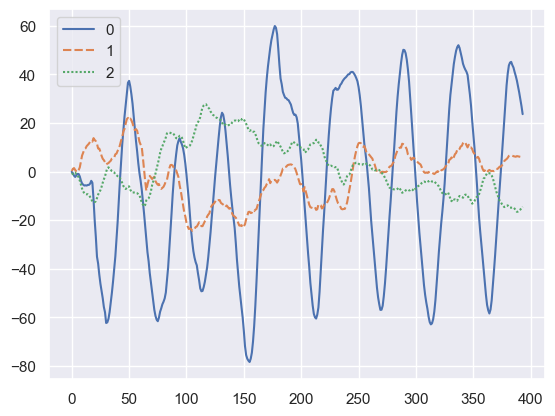

In [650]:
# Calculate time delta between samples in seconds
deltat = reSampleRate#numpy.average(numpy.diff(foreArmGData['Time (s)'].values))
# Calculate angle moved for each time step by integrating gyroscope data over time
angleSteps = gData * deltat
angleData = numpy.cumsum(angleSteps, axis=1)
degreeData = numpy.rad2deg(angleData)
seaborn.set(style="darkgrid")
a = seaborn.lineplot(data=degreeData[0])

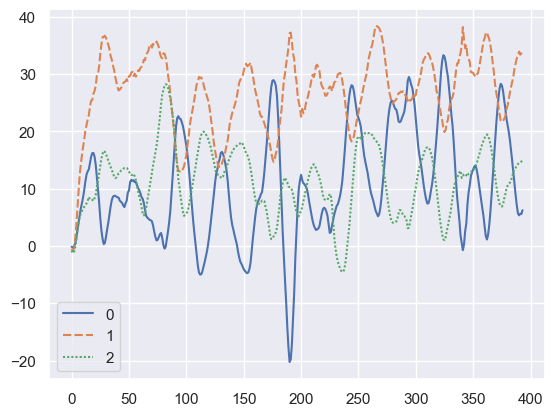

In [651]:

b = seaborn.lineplot(data=degreeData[1])

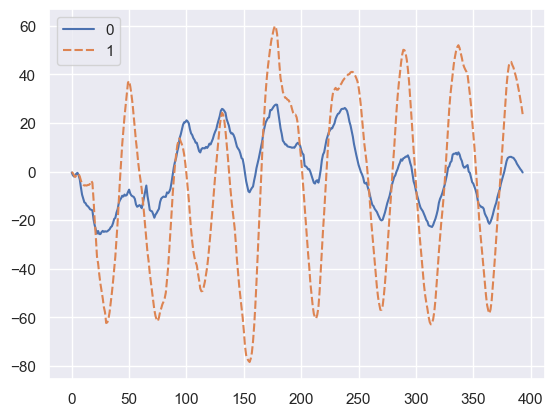

In [652]:
def getJEst(aEst):
    j1Est = numpy.array([numpy.cos(aEst[0][1])*numpy.cos(aEst[0][2]), numpy.cos(aEst[0][1])*numpy.sin(aEst[0][2]), numpy.sin(aEst[0][1])])
    j2Est = numpy.array([numpy.cos(aEst[1][1])*numpy.cos(aEst[1][2]), numpy.cos(aEst[1][1])*numpy.sin(aEst[1][2]), numpy.sin(aEst[1][1])])
    return numpy.array([j1Est, j2Est])


# Vector of angle and azimuth values for such that theta unit vector is parallel to x axis, perp to z and y (x axis is hinge axis)
aaVec = numpy.random.rand(2, 3)*numpy.pi*2#numpy.array([[1, numpy.rand, 0.2], [1, 0.1, 0.6]])
aaVec[0,0] = 1
aaVec[1,0] = 1
jEst = getJEst(aaVec)
aRates = numpy.dot(gData[0], jEst[0])
aAngles = aRates * deltat
aData = numpy.cumsum(aAngles)
degreeAData = numpy.rad2deg(aData)
a = seaborn.lineplot(data=[degreeAData, degreeData[0].T[0]])


<AxesSubplot: >

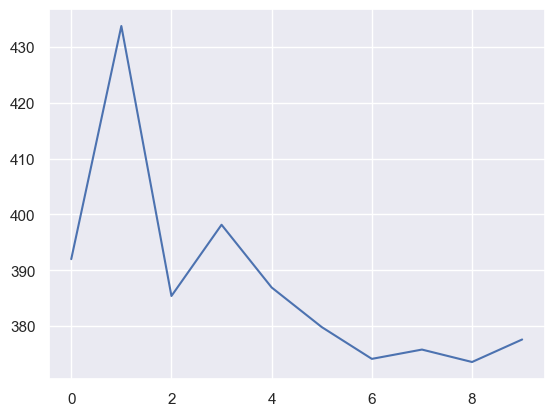

In [653]:
def getGJacobian(j, g):

    numerator1 = numpy.cross(numpy.cross(g[0], j[0]), g[0])
    denominator1 = numpy.linalg.norm(numpy.cross(g[0], j[0]), axis=1)
    grad1 = numpy.divide(numerator1.T, denominator1)
    numerator2 = numpy.cross(numpy.cross(g[1], j[1]), g[1])
    denominator2 = numpy.linalg.norm(numpy.cross(g[1], j[1]), axis=1)
    grad2 = numpy.divide(numerator2.T, denominator2)
    return(numpy.array([grad1.T, grad2.T]))

def getGErrorVector(j, g):
    left = numpy.linalg.norm(numpy.cross(j[0], g[0]), axis=1)
    right = numpy.linalg.norm(numpy.cross(j[1], g[1]), axis=1)
    errs = left - right
    return(errs)
    
# Get error vector
jEstimates = []
squares = []
for j in range(1):
    for i in range(10):
        gErrors = getGErrorVector(jEst, gData)
        sumS = numpy.sum(gErrors**2)
        # if (sumS < 50) & (i > 10):
        #     print(i)
        #     break
        # print(sumS)
        # Calculate Jacobian
        gJacobian = getGJacobian(jEst, gData)
        errJ = gJacobian[0] - gJacobian[1]
        # Calculate pseudoinverce
        gPseudoinverse = numpy.linalg.pinv(gJacobian)
        a = numpy.dot(gPseudoinverse, gErrors)
        # jEst = jEst - a
        aaVec = aaVec - a
        jEst = getJEst(aaVec)
        squares.append(sumS)
    jEstimates.append(jEst)

jEstimates = numpy.array(jEstimates)
# fig = plt.figure()
# ax = fig.add_subplot(111, projection = '3d')
# ax.scatter(jEstimates[:, 0, 0], jEstimates[:, 0, 1], jEstimates[:, 0, 2])
seaborn.lineplot(squares)


<AxesSubplot: >

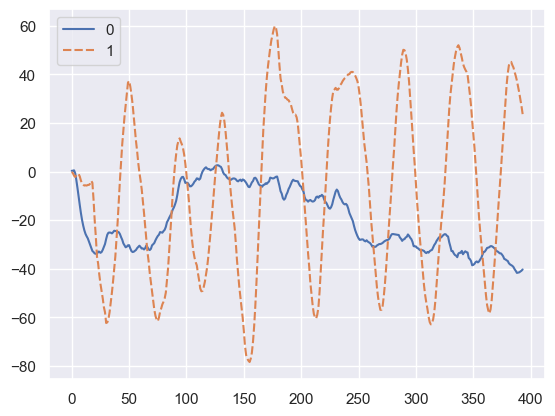

In [654]:

aRates1 = numpy.dot(gData[0], jEst[0])
aRates2 = numpy.dot(gData[1], jEst[1])
aAngles = (aRates1-aRates2) * deltat
aData = numpy.cumsum(aAngles)
degreeAData = numpy.rad2deg(aData)
seaborn.lineplot(data=[degreeAData, degreeData[0].T[0]])